In [1]:
import itertools
import timeit

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dynasor.core.reciprocal import calc_rho_q, calc_rho_j_q

In [2]:
sizes = 2**np.arange(1, 8)
print(sizes)

[  2   4   8  16  32  64 128]


In [3]:
def xvq(Nx, Nq):
    """Returns suitable arrays used in rho_q and rho_j_q"""
    x = np.random.normal(size=(Nx, 3))
    v = np.random.normal(size=(Nx, 3))
    q = np.random.normal(size=(Nq, 3))
    return x, v, q

In [4]:
# Here we force numba to compile the functions
x, v, q = xvq(2, 2)
calc_rho_q(x, q)
calc_rho_j_q(x, v, q)

(array([1.16435931+0.52618282j, 1.15045451-0.28636197j]),
 array([[ 1.66779075+0.12925628j, -0.03102259-0.17115886j,
          0.8197776 +0.09857148j],
        [ 1.24151343-1.05491643j, -0.13291369-0.15462083j,
          0.63304868-0.4823513j ]]))

In [6]:
# Main loop

data = []
functions = dict(rho_q='calc_rho_q(x, q)', rho_j_q='calc_rho_j_q(x, v, q)')
size_pairs = itertools.product(sizes, repeat=2)

for (func, func_str), (Nx, Nq) in itertools.product(
    functions.items(), size_pairs):
    x, v, q = xvq(Nx, Nq)

    timer = timeit.Timer(func_str, globals=globals())
    N, T = timer.autorange()
    print('numba', func, Nx, Nq, T/N, end=' '*10 + '\r')
    data.append(dict(Nx=Nx, Nq=Nq, t=T/N, backend='numba', func=func))

In [7]:
DF = pd.DataFrame(data)
print(DF)

     Nx   Nq         t backend     func
0     2    2  0.000007   numba    rho_q
1     2    4  0.000006   numba    rho_q
2     2    8  0.000007   numba    rho_q
3     2   16  0.000010   numba    rho_q
4     2   32  0.000006   numba    rho_q
..  ...  ...       ...     ...      ...
93  128    8  0.000029   numba  rho_j_q
94  128   16  0.000060   numba  rho_j_q
95  128   32  0.000026   numba  rho_j_q
96  128   64  0.000043   numba  rho_j_q
97  128  128  0.000080   numba  rho_j_q

[98 rows x 5 columns]


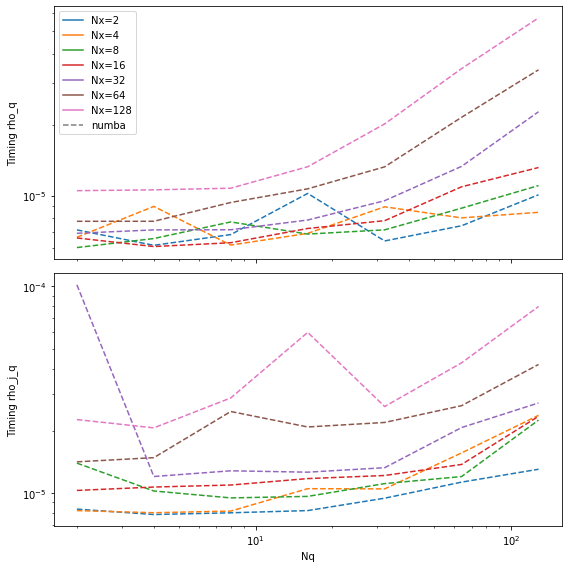

In [8]:
fig, axes = plt.subplots(2, sharex=True, figsize=(8,8))

ax = axes[0]
for Nx in sorted(set(DF.Nx)):
    df = DF[(DF.Nx == Nx) & (DF.backend=='c') & (DF.func=='rho_q')]
    l, = ax.loglog(df.Nq, df.t, ls='-', label=f'Nx={Nx}')
    df = DF[(DF.Nx == Nx) & (DF.backend=='numba') & (DF.func=='rho_q')]
    ax.loglog(df.Nq, df.t, ls='--', label=f'_Nx={Nx}', color=l.get_color())
ax.set_ylabel('Timing rho_q')

ax = axes[1]
for Nx in sorted(set(DF.Nx)):
    df = DF[(DF.Nx == Nx) & (DF.backend=='c') & (DF.func=='rho_j_q')]
    l, = ax.loglog(df.Nq, df.t, ls='-', label=f'Nx={Nx}')
    df = DF[(DF.Nx == Nx) & (DF.backend=='numba') & (DF.func=='rho_j_q')]
    ax.loglog(df.Nq, df.t, ls='--', label=f'_Nx={Nx}', color=l.get_color())
ax.set_ylabel('Timing rho_j_q')


axes[1].set_xlabel('Nq')
axes[0].plot([],[],ls='--', label='numba')
axes[0].legend()
fig.tight_layout()
fig.savefig('timings.pdf')
#fig.show()